## The Transient Universe


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.



In [29]:
import numpy as np
import matplotlib.pyplot as plt

import emcee

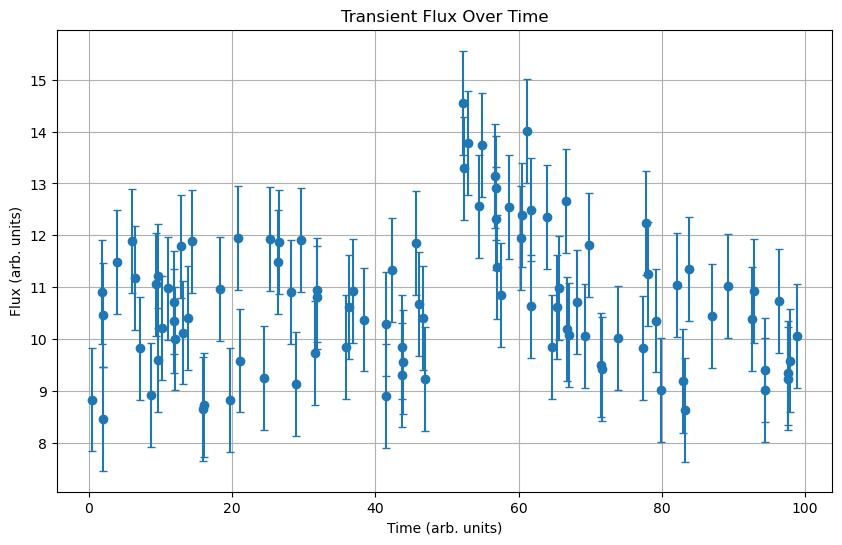

In [30]:
# Load the data
data = np.load('../solutions/transient.npy')  # Shape: (100, 3)

# Extract columns
time = data[:, 0]
flux = data[:, 1]
uncertainty = data[:, 2]

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(time, flux, yerr=uncertainty, fmt='o', capsize=3, label='Flux with uncertainty')
plt.xlabel('Time (arb. units)')
plt.ylabel('Flux (arb. units)')
plt.title('Transient Flux Over Time')
plt.grid(True)


2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [36]:
def burst_model (t, t_0, b, A, alpha):
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array

def Likelihood(sigma, data, t, t_0, b, A, alpha): # burst_model, uncertainty(of flux), data
    # Gaussian likelihood 
    model = burst_model (t, t_0, b, A, alpha)
    return np.prod(np.exp(-(data - model)**2 /2 /sigma**2))

def Prior(t_0, b, A, alpha):
    if 0 <= b <= 50 and 0 <= A <= 50 and 0 <= t_0 <= 100 and -5 <= np.log(alpha) <= 5:
        return 1
    else:
        return 0
    
def myPosterior(sigma, data, t, t_0, b, A, alpha): # emcee wants a function that takes a vector in the parameter space as input
    return Likelihood(sigma, data, t, t_0, b, A, alpha) * Prior(t_0, b, A, alpha)

# emcee wants ln of posterior pdf
def myLogPosterior(theta, x, sigma, data):
    t_0, b, A, alpha = theta
    return np.log(myPosterior(x, sigma, data, t_0, b, A, alpha))


In [40]:
## Ready to use emcee

ndim = 4  # number of parameters in the model
nwalkers = 8 # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

#-- MCMC IMPLEMENTATION ----------------------------------
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[uncertainty, data, time])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim) # sampler.chain[:, burn:, :] removes the first burn steps for each walker (burn-in)
                                                            # .reshape(-1, ndim) flattens the remaining samples into a 2D array: one row per sample.

# THINNING: Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time() # vector with autocorrelation times for each parameter
print(f"Autocorrelation time", tau)
thin = int(tau+1)

emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten() # flattens the array emcee_trace into a 1D array, discard burn point, thinning
# len(emcee_trace)

C:\Users\simon\AppData\Local\Temp\ipykernel_14692\582464646.py:21: RuntimeWarning: divide by zero encountered in log
  return np.log(myPosterior(x, sigma, data, t_0, b, A, alpha))
C:\Users\simon\AppData\Local\Temp\ipykernel_14692\582464646.py:10: RuntimeWarning: invalid value encountered in log
  if 0 <= b <= 50 and 0 <= A <= 50 and 0 <= t_0 <= 100 and -5 <= np.log(alpha) <= 5:
C:\Users\simon\AppData\Local\Temp\ipykernel_14692\582464646.py:7: RuntimeWarning: overflow encountered in square
  return np.prod(np.exp(-(data - model)**2 /2 /sigma**2))
C:\Users\simon\AppData\Local\Temp\ipykernel_14692\582464646.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array
C:\Users\simon\AppData\Local\Temp\ipykernel_14692\582464646.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array


Autocorrelation time [148.03759808 148.83406895 146.24783095 151.10482952]


TypeError: only length-1 arrays can be converted to Python scalars

Plot

In [ ]:
chainE = emcee_trace #[0] 

#-- Trace Plot ------------- 
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE) # plot chain over time 
#ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=15)
plt.ylabel('chain',fontsize=15)


"""
#-- RIGHT SUBPLOT: histo + gaussian comparison ------------
ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
#Create histo:
Nhist, bins, patches = plt.hist(chainE, bins='auto', histtype='stepfilled',density=True)

# plot expectations based on central limit theorem, you're comparing your posterior distribution to a normal distribution predicted by the Central Limit Theorem (CLT)
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
#ax2.set_xlim(0.7, 1.3)
#ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15) """

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 
